# Project 3: Modeling
----

### Data Dictionary


| Feature          | Type   | Dataset         | Description                                                                                                                                                   |
|------------------|--------|-----------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|
| text      | object | text_base  | The title and selftext of each Reddit post                                                                                                         |
| subreddit         | object  | text_base  | Which subreddit post belongs to                                                                                                     |
| neg       | float  | text_base  | The Negative value of the sentiment score of text                                                                                   |
| neu              | float  | text_base | The Neutral value of the sentiment score of text                                                            |
| pos           | float | text_base        | The Positive value of the sentiment score of text                                                                      |
| compound   | float  | text_base        | The Compound value of the sentiment score of text                                                                         |


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score,precision_score,recall_score,f1_score,plot_roc_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV
from scipy.stats import uniform, loguniform

import pickle

from nltk.corpus import stopwords

In [6]:
df = pd.read_csv('./data/text_base.csv')

In [7]:
df.head(1)

,text,subreddit,neg,neu,pos,comp
0,What is Twitter?,explainlikeimfive,0.0,1.0,0.0,0.0


In [8]:
df['subreddit']=df['subreddit'].apply(lambda x: 1 if x == 'explainlikeimfive' else 0)

For the sake of modeling we will be turning our target variable, subreddit, into a binary column.

In [9]:
X = df['text']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3,random_state = 42)

In [10]:
y.value_counts(normalize=True)

0    0.502055
1    0.497945
Name: subreddit, dtype: float64

In [11]:
X_train.shape

(66598,)

Looks like our baseline is pretty evenly distributed. If we were to make a prediction right now which subreddit a post belonged to we'd have 50% chance of getting it right.

## Models

#### Note: All completed models with best parameters are pickled into the models folder, feel free to run them from there.

#### CVEC MultinomialNB

In [12]:
# MultinomialNB
c_pipe_naive = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

c_naive_params = {
     'cvec__max_features': [1000,2000,3000],
     'cvec__min_df': [2, 3],
#      'cvec__max_df': [0.75, 0.9],
     'cvec__ngram_range':[(1, 1), (1, 2)],
     'cvec__stop_words':['english']
}

gs_cvec_nb = GridSearchCV(c_pipe_naive, 
                      param_grid = c_naive_params,
                      cv = 5)

gs_cvec_nb.fit(X_train, y_train)

In [10]:
# with open('./models/gs_cvec_nb.pkl', 'wb') as pickle_out:
#     pickle_out = pickle.dump(gs_cvec_nb.best_estimator_, pickle_out)

gs_cvec_nb = pickle.load(open('./models/gs_cvec_nb.pkl', 'rb'))

#### Cvec Logistic Regression

In [29]:
# LogisticRegression
c_pipe_logreg = Pipeline([
    ('cvec', CountVectorizer()),
    ('log', LogisticRegression(solver='liblinear',random_state=42))
     ])

c_log_params = {
    'cvec__max_features': [1000, 2000,3000,4000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.75,0.9],
    'cvec__ngram_range':[(1, 1), (1, 2)],
    'cvec__stop_words':[None,'english'],
    'log__penalty':['l1','l2'],
    'log__max_iter': [50_000],
    #'log__tol': [0.01]
}
gs_cvec_log = GridSearchCV(c_pipe_logreg, 
                      c_log_params,
                      cv = 5,)

gs_cvec_log.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('log',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.75, 0.9],
                         'cvec__max_features': [1000, 2000, 3000, 4000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'log__max_iter': [50000],
                         'log__penalty': ['l1', 'l2']})

In [30]:
# with open('./models/gs_cvec_log5.pkl', 'wb') as pickle_out:
#     pickle_out = pickle.dump(gs_cvec_log.best_estimator_, pickle_out)

In [12]:
gs_cvec_log = pickle.load(open('./models/gs_cvec_log5.pkl', 'rb'))

#### Cvec RandomForest

In [ ]:
# RandomForestClassifier
c_pipe_rf = Pipeline([
    ('cvec', CountVectorizer(ngram_range=(1,2))),
    ('rf', RandomForestClassifier())
])

c_rf_params = {
    'cvec__max_features': Integer(1000,4000),
    'cvec__min_df': Integer(2, 3),
    'cvec__max_df': Real(0.75,0.9),
    #'cvec__ngram_range':Categorical([(1, 1), (1, 2)]),
    'cvec__stop_words':Categorical([None,'english']),
    'rf__n_estimators': Integer(300, 500),
    'rf__max_depth': Integer(1, 5)
}


pleasefortheloveof = BayesSearchCV(estimator = c_pipe_rf,
                                   search_spaces = c_rf_params,
                     scoring = 'f1',
                     n_iter = 50,
                     #n_jobs = ,
                     cv = 5,
                     verbose = 1,
                     #refit = True,
                     #optimizer_kwargs = {'base_estimator': 'RF'},
                     random_state=42)

pleasefortheloveof.fit(X_train,y_train)


In [68]:
pleasefortheloveof.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=1000, min_df=3,
                                 ngram_range=(1, 2))),
                ('rf', RandomForestClassifier(max_depth=5, n_estimators=500))])

In [67]:
# with open('./models/bayes_cvec_rf.pkl', 'wb') as pickle_out:
#     pickle_out = pickle.dump(pleasefortheloveof.best_estimator_, pickle_out)

In [13]:
bayes_cvec_rf = pickle.load(open('./models/bayes_cvec_rf.pkl', 'rb'))

#### TFIDF Logistic Regression

In [82]:
# LogisticRegression
t_pipe_logreg = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('log', LogisticRegression(solver='liblinear',max_iter=50_000,random_state=42))
])

t_log_params = {
    'tfid__max_features': [1000, 2000, 3000, 4000],
    'tfid__min_df': [2, 3],
    'tfid__max_df': [0.75,0.9],
    'tfid__ngram_range':[(1, 1), (1, 2)],
    'tfid__stop_words':['english',None],
    'log__penalty':['l1','l2']
}

gs_tfidf_log = GridSearchCV(t_pipe_logreg, 
                      t_log_params,
                      cv = 5,)

gs_tfidf_log.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfid', TfidfVectorizer()),
                                       ('log',
                                        LogisticRegression(max_iter=50000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'log__penalty': ['l1', 'l2'],
                         'tfid__max_df': [0.75, 0.9],
                         'tfid__max_features': [1000, 2000, 3000, 4000],
                         'tfid__min_df': [2, 3],
                         'tfid__ngram_range': [(1, 1), (1, 2)],
                         'tfid__stop_words': ['english', None]})

In [83]:
# with open('./models/gs_tfidf_log.pkl', 'wb') as pickle_out:
#     pickle_out = pickle.dump(gs_tfidf_log.best_estimator_, pickle_out)

In [14]:
gs_tfidf_log = pickle.load(open('./models/gs_tfidf_log.pkl', 'rb'))

#### Tfidf RandomForest

In [ ]:
# RandomForestClassifier
t_pipe_rf = Pipeline([
    ('tfid', TfidfVectorizer(ngram_range=(1,2))),
    ('rf', RandomForestClassifier())
])

t_rf_params = {
    'tfid__max_features': Integer(1000, 5000),
    'tfid__min_df': Integer(2, 3),
    'tfid__max_df': Real(0.75,0.9),
    #'tfid__ngram_range':[(1, 1), (1, 2)],
    'tfid__stop_words':Categorical([None,'english']),
    'rf__n_estimators': Integer(200, 500),
    'rf__max_depth': Integer(1, 5)
}

bayes_tfidf_rf = BayesSearchCV(estimator = t_pipe_rf,
                                   search_spaces = t_rf_params,
                     scoring = 'f1',
                     n_iter = 50,
                     #n_jobs = ,
                     cv = 5,
                     verbose = 1,
                     #refit = True,
                     #optimizer_kwargs = {'base_estimator': 'RF'},
                     random_state=42)

bayes_tfidf_rf.fit(X_train,y_train)

In [73]:
bayes_tfidf_rf.best_estimator_

Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.75, max_features=1000, min_df=2,
                                 ngram_range=(1, 2))),
                ('rf', RandomForestClassifier(max_depth=5, n_estimators=500))])

In [74]:
# with open('./models/bayes_tfidf_rf.pkl', 'wb') as pickle_out:
#     pickle_out = pickle.dump(bayes_tfidf_rf.best_estimator_, pickle_out)

In [15]:
bayes_tfidf_rf = pickle.load(open('./models/bayes_tfidf_rf.pkl', 'rb'))

## Model Scores

In [23]:
gs_cvec_log.fit(X_train,y_train)
gs_cvec_nb.fit(X_train,y_train)
gs_tfidf_log.fit(X_train,y_train)
bayes_cvec_rf.fit(X_train,y_train)
bayes_tfidf_rf.fit(X_train,y_train)

Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.75, max_features=1000, min_df=2,
                                 ngram_range=(1, 2))),
                ('rf', RandomForestClassifier(max_depth=5, n_estimators=500))])

#### Cvec Logistic Regression

In [49]:
cvec_log_preds = gs_cvec_log.predict(X_test)
print(f'Accuracy:{gs_cvec_log.score(X_train,y_train), gs_cvec_log.score(X_test,y_test)}, Recall:{recall_score(y_test,cvec_log_preds)}, Precision:{precision_score(y_test,cvec_log_preds)}, F1:{f1_score(y_test,cvec_log_preds)}')


Accuracy:(0.8200096098981952, 0.797638650457205), Recall:0.8189280202048548, Precision:0.7851089588377724, F1:0.801661973765538


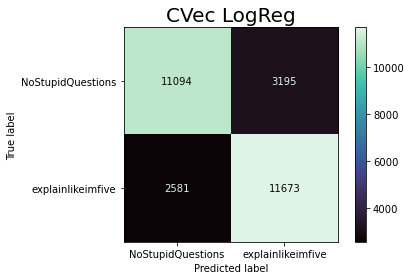

In [86]:
tn, fp, fn, tp = confusion_matrix(y_test, cvec_log_preds).ravel()
plot_confusion_matrix(gs_cvec_log,X_test,y_test, 
                      display_labels=['NoStupidQuestions', 'explainlikeimfive'],
                     cmap='mako');
plt.title('CVec LogReg',size=20);
plt.tight_layout();
#plt.savefig('./imgs/matrix_cvec_log.png');

#### Tfidf Logistic Regression

In [82]:
tfidf_log_preds = gs_tfidf_log.predict(X_test)

print(f'Accuracy: {gs_tfidf_log.score(X_train,y_train), gs_tfidf_log.score(X_test,y_test)}, Recall: {recall_score(y_test,tfidf_log_preds)}, Precision: {precision_score(y_test,tfidf_log_preds)}, F1: {f1_score(y_test,tfidf_log_preds)}')


Accuracy: (0.820039640830055, 0.8001961952142381), Recall: 0.7985828539357374, Precision: 0.8007738304607809, F1: 0.7996768414766939


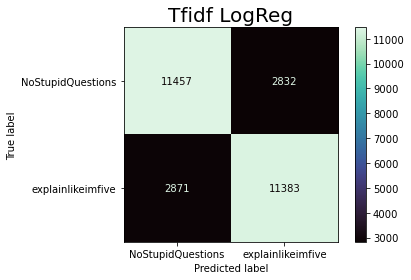

In [87]:
tn, fp, fn, tp = confusion_matrix(y_test, tfidf_log_preds).ravel()
plot_confusion_matrix(gs_tfidf_log,X_test,y_test, 
                      display_labels=['NoStupidQuestions', 'explainlikeimfive'],
                     cmap='mako');
plt.title('Tfidf LogReg',size=20);
plt.tight_layout()
#plt.savefig('./imgs/matrix_tfidf_log.png');

#### Cvec Niave Bayes

In [88]:
cvec_nb_preds = gs_cvec_nb.predict(X_test)

print(f'Accuracy: {gs_cvec_nb.score(X_train,y_train)}, {gs_cvec_nb.score(X_test,y_test)}, Recall: {recall_score(y_test,cvec_nb_preds)}, Precision: {precision_score(y_test,cvec_nb_preds)}, F1: {f1_score(y_test,cvec_nb_preds)}')

Accuracy: 0.7520646265653623, 0.7402515502925411, Recall: 0.7973902062578925, Precision: 0.7152026176692675, F1: 0.7540635573542094


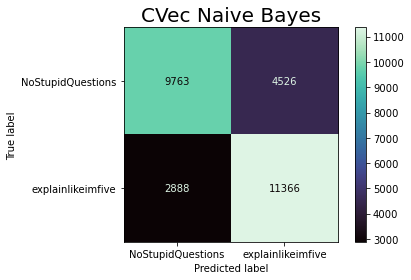

In [89]:
tn, fp, fn, tp = confusion_matrix(y_test, cvec_nb_preds).ravel()
plot_confusion_matrix(gs_cvec_nb,X_test,y_test, 
                      display_labels=['NoStupidQuestions', 'explainlikeimfive'],
                     cmap='mako');
plt.title('CVec Naive Bayes',size=20);
plt.tight_layout()
#plt.savefig('./imgs/matrix_cvec_nb.png');

#### Cvec RandomForest

In [90]:
cvec_rf_preds = bayes_cvec_rf.predict(X_test)

print(f'Accuracy: {bayes_cvec_rf.score(X_train,y_train), bayes_cvec_rf.score(X_test,y_test)}, Recall: {recall_score(y_test,cvec_rf_preds)}, Precision: {precision_score(y_test,cvec_rf_preds)}, F1: {f1_score(y_test,cvec_rf_preds)}')

Accuracy: (0.7082044505841016, 0.7067932592929965), Recall: 0.7601375052616809, Precision: 0.686411149825784, F1: 0.7213955191584274


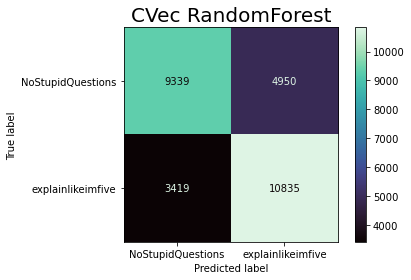

In [91]:
tn, fp, fn, tp = confusion_matrix(y_test, cvec_rf_preds).ravel()
plot_confusion_matrix(bayes_cvec_rf,X_test,y_test, 
                      display_labels=['NoStupidQuestions', 'explainlikeimfive'],
                     cmap='mako');
plt.title('CVec RandomForest',size=20);
plt.tight_layout()
#plt.savefig('./imgs/matrix_cvec_rf.png');

#### Tfidf RandomForest

In [92]:
tfidf_rf_preds = bayes_tfidf_rf.predict(X_test)

print(f'Accuracy: {bayes_tfidf_rf.score(X_train,y_train), bayes_tfidf_rf.score(X_test,y_test)}, Recall: {recall_score(y_test,tfidf_rf_preds)}, Precision: {precision_score(y_test,tfidf_rf_preds)}, F1: {f1_score(y_test,tfidf_rf_preds)}')

Accuracy: (0.7123036727829665, 0.7113477910520969), Recall: 0.7590851690753473, Precision: 0.69248, F1: 0.7242544931222598


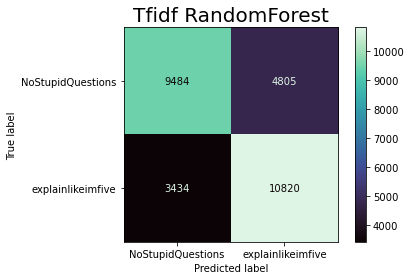

In [93]:
tn, fp, fn, tp = confusion_matrix(y_test, tfidf_rf_preds).ravel()
plot_confusion_matrix(bayes_tfidf_rf,X_test,y_test, 
                      display_labels=['NoStupidQuestions', 'explainlikeimfive'],
                     cmap='mako');
plt.title('Tfidf RandomForest',size=20);
plt.tight_layout()
#plt.savefig('./imgs/matrix_tfidf_rf.png');

| Model                        | Training Score              | Testing Score               | Recall             | Precision          | F1                 |
|------------------------------|-----------------------------|-----------------------------|--------------------|--------------------|--------------------|
|       CVec/RandomForest      |      0.7082044505841016     |      0.7067932592929965     | 0.7601375052616809 | 0.686411149825784  | 0.7213955191584274 |
| TfidfVect/RandomForest       | 0.7123036727829665          | 0.7113477910520969          | 0.7590851690753473 | 0.69248            | 0.7242544931222598 |
| CVec/Multinomial Naive Bayes | 0.7520646265653623          | 0.7402515502925411          | 0.7973902062578925 | 0.7152026176692675 | 0.7540635573542094 |
| CVec/Logistic Regression     | 0.8200096098981952          | 0.797638650457205           | 0.8189280202048548 | 0.7851089588377724 | 0.801661973765538  |
| Tfidf/Logistic Regression    | 0.820039640830055           | 0.8001961952142381          | 0.7985828539357374 | 0.8007738304607809 | 0.7996768414766939 |
| BASE                         | NoStupidQuestions: 0.502055 | explainlikeimfive: 0.497945 |                    |                    |                    |

Looking at the above models it appears that Tfidif Logistic Regression did the best. We care less about False Positives and False Negatives so Recall and Precision aren't as helpful as Accuracy and F1 score which are all about even. I will opt for the highes testing score.

<Figure size 864x864 with 0 Axes>

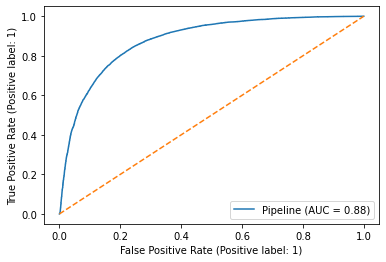

In [109]:
# ROC curve
plot_roc_curve(gs_tfidf_log, X_test, y_test);
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--");

An easy visual representation to see how effective our model is. While not the best model, definitley has room for error, it is about 30% more effective at guessing than the baseline.